# Neural network regression

In this many-to-one regression setup, we stack the series from all inverters into a long vector and try to predict the aggregate power a few steps ahead. First we load the data and get rid of NaNs:

In [1]:
import pandas as pd

df = pd.read_csv('data/data.csv').fillna(0)

 We define the problem and a set of hyperparemeters to tune later:

In [2]:
from core.problems import ManyToOneRegression

# Problem parameters
window = 256 # window size (to be determined from correlation analysis)
future = 50  # prediction window into the future

# Optimization parameters
nepochs = 50
batchsize = 1000

problem = ManyToOneRegression(df, window=window, future=future)

## Training

In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, LSTM
from keras.optimizers import Adamax, SGD
from keras.callbacks import TensorBoard, EarlyStopping

# FULLY CONNECTED SHALLOW ARCHITECTURE
model = Sequential([
    Dense(100, input_shape=(problem.inputdim(),)),
    Activation('relu'),
    Dense(80),
    Activation('relu'),
    Dense(problem.outputdim()),
    Activation('linear')
])

# UNCOMMENT FOR DEBUGGING
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# display(SVG(model_to_dot(model).create(prog='dot', format='svg')))

model.compile(loss='mean_squared_error',
              optimizer=Adamax(),
              metrics=['mean_squared_error'])

tboard = TensorBoard()

# after hours trying to debug Keras in order to use model.fit_generator(),
# I decided to just do it manually for now:
sampler = problem.sampler(batchsize=batchsize)
for _ in range(nepochs):
    X, Y = next(sampler)
    model.fit(X, Y, batch_size=50, epochs=1, validation_split=.1, callbacks=[tboard])

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 1s 765us/step - loss: 9492.3991 - mean_squared_error: 9492.3991 - val_loss: 3212.4233 - val_mean_squared_error: 3212.4233
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 1s 744us/step - loss: 2066.8450 - mean_squared_error: 2066.8450 - val_loss: 1419.0325 - val_mean_squared_error: 1419.0325
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 1s 816us/step - loss: 1339.7918 - mean_squared_error: 1339.7918 - val_loss: 1087.9094 - val_mean_squared_error: 1087.9094
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 1s 790us/step - loss: 963.9206 - mean_squared_error: 963.9206 - val_loss: 831.5355 - val_mean_squared_error: 831.5355
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 1s 894us/step - loss:

900/900 [==============================] - 1s 877us/step - loss: 715.2031 - mean_squared_error: 715.2031 - val_loss: 401.2320 - val_mean_squared_error: 401.2320
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 1s 742us/step - loss: 630.4709 - mean_squared_error: 630.4709 - val_loss: 984.2444 - val_mean_squared_error: 984.2444
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 1s 732us/step - loss: 745.0282 - mean_squared_error: 745.0282 - val_loss: 589.3445 - val_mean_squared_error: 589.3445
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 1s 1ms/step - loss: 736.1333 - mean_squared_error: 736.1333 - val_loss: 642.5973 - val_mean_squared_error: 642.5973
Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 1s 1ms/step - loss: 661.6331 - mean_squared_error: 661.6331 - val_loss: 513.2465 - val_mean

## Prediction

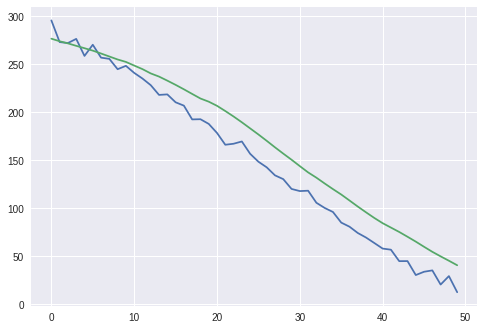

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

t = 0 # make predictions at this time

x, y = problem.featurize(t)
yhat = model.predict(np.array([x]))

plt.plot(yhat.T)
plt.plot(y)
plt.show()